In [1]:
using Pkg 
Pkg.activate("..")

  Activating project at `~/code/PhasorNetworks.jl`


In [2]:
include("../src/PhasorNetworks.jl")
using .PhasorNetworks, Plots, DifferentialEquations

In [3]:
using Lux, MLUtils, MLDatasets, OneHotArrays, Statistics, Test, LuxCUDA
using Random: Xoshiro, AbstractRNG
using Base: @kwdef
using Zygote: withgradient
using Optimisers, ComponentArrays
using Statistics: mean
using LinearAlgebra: diag
using PhasorNetworks: bind
using Distributions: Normal
using DifferentialEquations: Heun, Tsit5

In [4]:
solver_args = Dict(:adaptive => false, :dt => 0.01)

spk_args = SpikingArgs(threshold = 0.001,
                    solver=Tsit5(), 
                    solver_args = solver_args)

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [5]:
cdev = cpu_device()
gdev = gpu_device()

(::CUDADevice{Nothing}) (generic function with 1 method)

In [6]:
#global args for all tests
n_x = 101
n_y = 101
n_vsa = 1
epsilon = 0.10
repeats = 10
epsilon = 0.025


tspan = (0.0, repeats*1.0)
tbase = collect(tspan[1]:spk_args.solver_args[:dt]:tspan[2])

@kwdef mutable struct Args
    η::Float64 = 3e-4       ## learning rate
    batchsize::Int = 256    ## batch size
    epochs::Int = 10        ## number of epochs
    use_cuda::Bool = false   ## use gpu (if cuda available)
    rng::Xoshiro = Xoshiro(42) ## global rng
end

Args

In [8]:
c_args = Args(use_cuda = false)
g_args = Args(use_cuda = true)

Args(0.0003, 256, 10, true, Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e))

# Static

In [14]:
x_in = random_symbols((1024, 64), c_args.rng)

1024×64 Matrix{Float64}:
  0.640282    0.945132    0.889042    0.0516839  …  -0.00984287   0.639849
 -0.155483    0.733995   -0.994387    0.468782      -0.88008      0.629702
  0.358575    0.932527    0.469045    0.402625       0.210171    -0.741947
  0.475655   -0.76772    -0.369917    0.854612       0.10608      0.281374
 -0.833544    0.726934    0.283175    0.416894       0.688417    -0.41601
 -0.798331    0.921875   -0.507359   -0.294106   …   0.213244    -0.62336
 -0.963273    0.582896    0.0455585   0.20835        0.856121    -0.208856
 -0.357869   -0.574464    0.914467   -0.246017       0.112304     0.0489283
  0.162481    0.291449    0.0410464  -0.853106      -0.421677     0.4122
  0.93903    -0.0757589  -0.0828869   0.196618       0.602356     0.404546
 -0.56927    -0.62585     0.862634   -0.0177228  …  -0.920396    -0.284156
 -0.974203   -0.667565   -0.905031    0.542183      -0.458338    -0.272394
 -0.682606    0.499086    0.110283    0.961125       0.735084     0.91838
  ⋮ 

In [16]:
layer = Chain(PhasorDense(1024 => 16),)

Chain(
    layer_1 = PhasorDense((1024, 16)),  # 16_416 parameters
)         # Total: 16_416 parameters,
          #        plus 0 states.

In [19]:
ps, st = Lux.setup(c_args.rng, layer)

((layer_1 = (weight = Float32[0.045519598 0.01817569 … 0.013574537 0.034759175; 0.005412759 0.053698212 … -0.0070794793 0.0034227206; … ; 0.0046501816 0.08916628 … 0.02670388 -0.018784158; -0.024777878 -0.0021090682 … 0.039151974 -0.035482846], bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]),), (layer_1 = NamedTuple(),))

In [26]:
y, _ = layer(x_in, ps, st)

([0.10826252709368818 0.06754642758726764 … -0.20901909317033263 0.6164749733074082; 0.12093616076962323 0.0893195460182369 … 0.001584714979984909 0.2141974136095966; … ; -0.20962624976388702 -0.1948699522014995 … -0.24360969304496816 -0.012431509398492144; 0.20291833418535038 0.1542217375379109 … -0.011865875213283219 -0.22547764155214772], (layer_1 = NamedTuple(),))

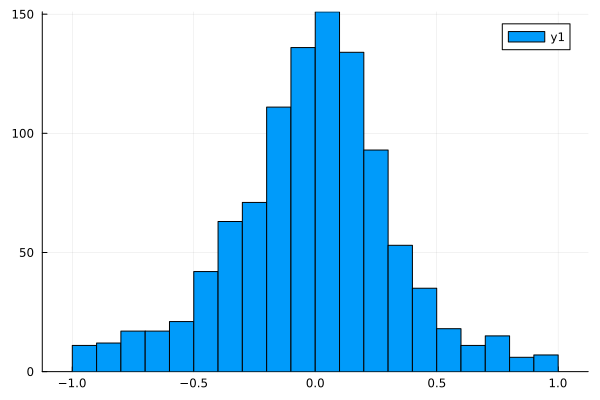

In [28]:
histogram(vec(y))

In [29]:
ps_g = gdev(ps)
st_g = gdev(st)
x_in_g = gdev(x_in)

1024×64 CuArray{Float32, 2, CUDA.DeviceMemory}:
  0.640282    0.945132    0.889042    0.0516839  …  -0.00984287   0.639849
 -0.155483    0.733995   -0.994387    0.468782      -0.88008      0.629702
  0.358575    0.932527    0.469045    0.402625       0.210171    -0.741947
  0.475655   -0.76772    -0.369917    0.854612       0.10608      0.281374
 -0.833544    0.726934    0.283175    0.416894       0.688417    -0.41601
 -0.798331    0.921875   -0.507359   -0.294106   …   0.213244    -0.62336
 -0.963273    0.582896    0.0455585   0.20835        0.856121    -0.208856
 -0.357869   -0.574464    0.914467   -0.246017       0.112304     0.0489283
  0.162481    0.291449    0.0410464  -0.853106      -0.421677     0.4122
  0.93903    -0.0757589  -0.0828869   0.196618       0.602356     0.404546
 -0.56927    -0.62585     0.862634   -0.0177228  …  -0.920396    -0.284156
 -0.974203   -0.667565   -0.905031    0.542183      -0.458338    -0.272394
 -0.682606    0.499086    0.110283    0.961125       0.

In [30]:
y_g, _ = layer(x_in_g, ps_g, st_g)

(Float32[0.10826248 0.06754646 … -0.2090191 0.6164751; 0.12093613 0.0893196 … 0.0015847185 0.21419738; … ; -0.20962624 -0.1948699 … -0.24360968 -0.01243151; 0.20291834 0.15422171 … -0.011865864 -0.2254776], (layer_1 = NamedTuple(),))

In [ ]:
y2 = y_g |> cdev

16×64 Matrix{Float32}:
  0.108262    0.0675465   0.00842423  …  -0.209019     0.616475
  0.120936    0.0893196  -0.294195        0.00158472   0.214197
 -0.18257     0.232586    0.37593        -0.405445     0.129196
 -0.384294    0.15203    -0.15258        -0.0188649    0.0167223
 -0.461423   -0.52652     0.0312735      -0.041259     0.189509
 -0.301794    0.140206   -0.359491    …   0.174708    -0.317828
  0.227219    0.490008    0.887053        0.00237487   0.20871
 -0.297832   -0.747884    0.70023         0.511937    -0.354408
 -0.247062    0.0214227   0.102944       -0.0359039    0.223406
  0.0635916   0.059029    0.360794       -0.495704     0.458172
  0.237609   -0.107155    0.312322    …   0.287186     0.00398678
 -0.181222    0.0207942   0.162716        0.175716    -0.00294937
 -0.236976   -0.152143    0.158087       -0.0815386   -0.844659
 -0.0680892   0.206441    0.492357        0.0231801    0.0720322
 -0.209626   -0.19487     0.236385       -0.24361     -0.0124315
  0.202918 

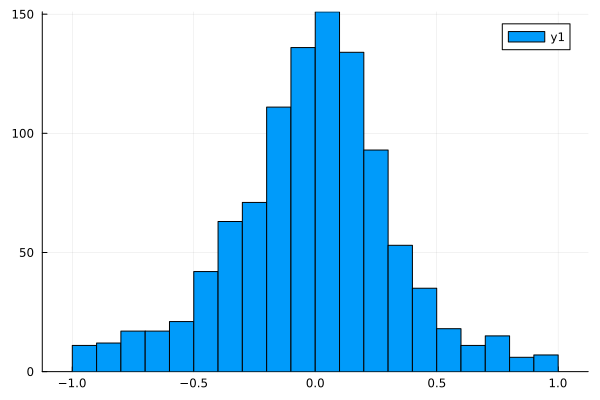

In [33]:
histogram(vec(y2))

In [35]:
maximum(y .- y2)

3.6995261215588826e-7

# Dynamic

In [36]:
st_x = phase_to_train(x_in, spk_args=spk_args)

Spike Train: (1024, 64) with 65536 spikes.

In [37]:
st_xg = SpikeTrainGPU(st_x)

SpikeTrainGPU(CartesianIndex{2}[CartesianIndex(1, 1), CartesianIndex(2, 1), CartesianIndex(3, 1), CartesianIndex(4, 1), CartesianIndex(5, 1), CartesianIndex(6, 1), CartesianIndex(7, 1), CartesianIndex(8, 1), CartesianIndex(9, 1), CartesianIndex(10, 1)  …  CartesianIndex(1015, 64), CartesianIndex(1016, 64), CartesianIndex(1017, 64), CartesianIndex(1018, 64), CartesianIndex(1019, 64), CartesianIndex(1020, 64), CartesianIndex(1021, 64), CartesianIndex(1022, 64), CartesianIndex(1023, 64), CartesianIndex(1024, 64)], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  65527, 65528, 65529, 65530, 65531, 65532, 65533, 65534, 65535, 65536], Float32[0.82014114, 0.42225844, 0.67928755, 0.7378274, 0.08322817, 0.10083455, 0.018363357, 0.32106572, 0.5812403, 0.969515  …  0.36562526, 0.25465935, 0.3796407, 0.1238485, 0.63501745, 0.78179777, 0.17782754, 0.49586594, 0.9383399, 0.029649138], (1024, 64), 65536, 0.0f0)

In [41]:
y_t, _ = layer(SpikingCall(st_x, spk_args, (0.0, 10.0)), ps, st)

(SpikingCall(Spike Train: (16, 64) with 10240 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0, 10.0)), (layer_1 = NamedTuple(),))

In [43]:
y_tp = train_to_phase(y_t);

In [47]:
y_tg, _ = layer(SpikingCall(st_xg, spk_args, (0.0, 10.0)), ps_g, st_g)

(SpikingCall(SpikeTrainGPU(CartesianIndex{2}[CartesianIndex(1, 1), CartesianIndex(2, 1), CartesianIndex(3, 1), CartesianIndex(4, 1), CartesianIndex(5, 1), CartesianIndex(6, 1), CartesianIndex(7, 1), CartesianIndex(8, 1), CartesianIndex(9, 1), CartesianIndex(10, 1)  …  CartesianIndex(7, 64), CartesianIndex(8, 64), CartesianIndex(9, 64), CartesianIndex(10, 64), CartesianIndex(11, 64), CartesianIndex(12, 64), CartesianIndex(13, 64), CartesianIndex(14, 64), CartesianIndex(15, 64), CartesianIndex(16, 64)], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024], Float32[1.8029516, 1.8110392, 1.6689162, 1.5399289, 1.5220934, 1.591979, 1.8643099, 1.6081438, 1.6273057, 1.7850746  …  10.759938, 10.740726, 10.7539215, 10.759321, 10.750123, 10.7499075, 10.746819, 10.753016, 10.749281, 10.744842], (16, 64), 1024, 0.25f0), Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0, 10.0)), (layer_1 = NamedTuple(),))

In [48]:
y_tpg = train_to_phase(y_tg);

In [49]:
typeof(y_tpg)

Array{Float64, 3}

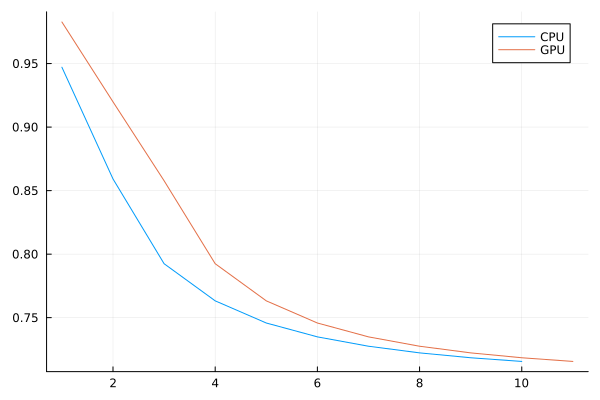

In [52]:
plot(cycle_correlation(y, y_tp), label = "CPU")
plot!(cycle_correlation(y, y_tpg), label="GPU")